# Leading-edge Slat Analysis

## The History of Leading-edge Slat

We have used NACA23012 airfoil to simulate flap and analyzed the lift in different conditions, which are different deflection angles and different attack angles. So, do we know exactly what flaps are? Are flaps always set behind the airfoil? 

First, flaps are high-lifting devices, which are mounted on the trailing edge of the wing to increase the lift generated and angle of descent. And there is also another kind of flap, which is set at the leading edge, call leading-edge slat.

We know that the flap allow the wing to operate at a higher angle of attack when the flap deployed. The leading-edge play the same role as other kinds of flap. 

In 1918, Gustav Lachmann developed the first slat. The first leading-edge slat presented a patent in Germany. However, Mr. Handley Page stated that it was impossible to get a good ratio of lift to resistance and a high maxmium lift with the same section, and it is necessary to have some variable device which will affect the air flow to get both combined in one plane, and then Handley also developed the slat. 


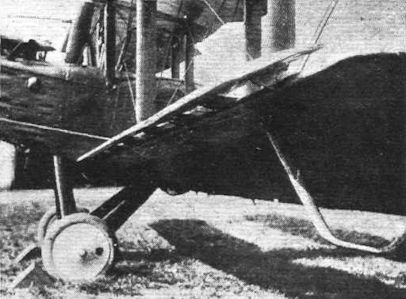

In [1]:
from IPython.display import Image
Image(filename='Handley.jpg')

During World War II, German developed a more advanced version. It allowed aircraft to take off in a light wind. The biggest aim in the earliest days was the production of a machine with a high degree of control. But accidents still occured and a big proportion were due to the pilot losing control of his machine through stalling and that is why Handley Page slot or slotted wing has been evolved. And at post world war II, slats were operated by hydraulics or electricity on larger aircraft, this is definitely one of the outstanding aeronautical development of recent years.

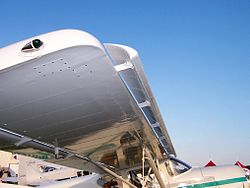

In [2]:
from IPython.display import Image
Image(filename='slatpicture.jpg')

What this project is do next is that using two-elements panel method finish thed analysis of the different lift coefficient by different overhang distances and different deflection angles.

## Set geometry of this two-elements airfoil

In this project I set NACA23012 as my main airfoil and I will scale the NACA23012 down as my slat. Since we have already learned how to use panel method in class, also the vortex-source panel method will be used. Now let us import our numpy library and define panel first. 

In [3]:
import numpy
import math
from matplotlib import pyplot
from scipy import integrate
%matplotlib inline

In [4]:
class Panel:
    def __init__(self, xa, ya, xb, yb):
        self.xa, self.ya = xa, ya # panel starting-point
        self.xb, self.yb = xb, yb # panel ending-point
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2         # panel center
        self.length = numpy.sqrt((xb-xa)**2+(yb-ya)**2) # panel length
        # orientation of panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.0:
            self.beta = numpy.arccos((yb-ya)/self.length)
        elif xb-xa > 0.0:
            self.beta = numpy.pi + numpy.arccos(-(yb-ya)/self.length)
        # panel location
        if self.beta <= numpy.pi:
            self.loc = 'upper' # upper surface
        else:
            self.loc = 'lower' # lower surface
        self.sigma = 0.0 # source strength
        self.vt = 0.0    # tangential velocity
        self.cp = 0.0    # pressure coefficient
        
        
def define_panels(x, y, N):
    # create panels
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x[i], y[i], x[i+1], y[i+1])
    return panels


class Freestream:
    def __init__(self, u_inf, alpha):
        self.u_inf = u_inf
        self.alpha = alpha*numpy.pi/180.0 # degrees to radians
        
        
def integral(x, y, panel, dxdk, dydk):
    def integrand(s):
        return ( ((x - (panel.xa - numpy.sin(panel.beta)*s))*dxdk
                  +(y - (panel.ya + numpy.cos(panel.beta)*s))*dydk)
                / ((x - (panel.xa - numpy.sin(panel.beta)*s))**2
                   +(y - (panel.ya + numpy.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]


def source_contribution_normal(panels):
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # source contribution on a panel from itself
    numpy.fill_diagonal(A, 0.5)
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, panel_j,numpy.cos(panel_i.beta),numpy.sin(panel_i.beta))
    return A


def vortex_contribution_normal(panels):
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    numpy.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                 panel_j,
                                                 numpy.sin(panel_i.beta),
                                                 -numpy.cos(panel_i.beta))
    return A


def kutta_condition(A_source, B_vortex):
    b = numpy.empty([2,A_source.shape[1]+2],dtype=float)
    b[0,:-2] = B_vortex[0, :] + B_vortex[N-1, :]
    b[1,:-2] = B_vortex[N, :] + B_vortex[2*N-1, :]
    
    b[-2,-2]=- numpy.sum(A_source[0,:N] + A_source[N-1,:N])
    b[-2,-1]=- numpy.sum(A_source[0,N:] + A_source[N-1,N:])
    b[-1,-2]=- numpy.sum(A_source[N,:N] + A_source[2*N-1,:N])
    b[-1,-1]=- numpy.sum(A_source[N,N:] + A_source[2*N-1,N:])
    
    return b


def build_singularity_matrix(A_source, B_vortex):
    A = numpy.empty((A_source.shape[0]+2, A_source.shape[0]+2), dtype=float)
    # source contribution matrix
    A[:-2, :-2] = A_source
    # vortex contribution array
    A[:-2, -2] = numpy.sum(B_vortex[:,:N], axis=1)    
    A[:-2, -1] = numpy.sum(B_vortex[:,N:], axis=1)
    # Kutta condition array
    A[-2:, :] = kutta_condition(A_source, B_vortex)
    return A


def build_freestream_rhs(panels, freestream):
    b = numpy.empty(panels.size+2,dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    # freestream contribution on the Kutta condition
    b[-2] = -freestream.u_inf*( numpy.sin(freestream.alpha-panels[0].beta)
                               +numpy.sin(freestream.alpha-panels[N-1].beta) )
    b[-1] = -freestream.u_inf*( numpy.sin(freestream.alpha-panels[N].beta)
                               +numpy.sin(freestream.alpha-panels[2*N-1].beta) )
    return b


def compute_pressure_coefficient(panels, freestream):
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

        
def compute_tangential_velocity(panels, freestream, gamma_m,gamma_f, A_source, B_vortex):
    A = numpy.empty((panels.size, panels.size+2), dtype=float)
    A[:, :-2] = B_vortex
    A[:, -2] = -numpy.sum(A_source[:,:N], axis=1)
    A[:, -1] = -numpy.sum(A_source[:,N:], axis=1)
    b = freestream.u_inf*numpy.sin([freestream.alpha-panel.beta 
                                    for panel in panels])
    strengths = numpy.append([panel.sigma for panel in panels],gamma_m)
    strengths = numpy.append(strengths,gamma_f)
    tangential_velocities = numpy.dot(A, strengths) + b
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]
        

def compute_pressure_coefficient(panels, freestream):
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [5]:
with open ('10023012.csv') as file_name:
    xmain, ymain = numpy.loadtxt(file_name, dtype=float,delimiter=',', unpack=True)
with open ('s10023012.csv') as file_name:
    xslat, yslat = numpy.loadtxt(file_name, dtype=float,delimiter=',', unpack=True)

In [6]:
def rotation(point,theta,x,y):
    theta1=theta/180*numpy.pi
    x_1,y_1=0,0
    x_1=x-point[0]
    y_1=y-point[1]
    x_r=x_1*numpy.cos(theta1)+y_1*numpy.sin(theta1)+point[0]
    y_r=x_1*(-1)*numpy.sin(theta1)+y_1*numpy.cos(theta1)+point[1]
    return x_r,y_r

In [7]:
xslat = xslat*0.6-0.08
yslat = yslat+0.02
xslat,yslat=rotation([xslat[51],yslat[51]],-20,xslat,yslat)

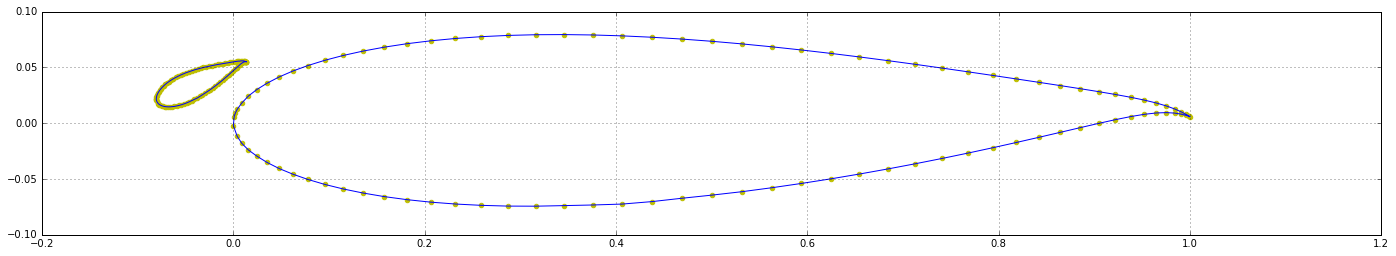

In [8]:
N=len(xslat)-1
pyplot.figure(figsize=(24,4))
pyplot.plot(xmain, ymain, color='b', linestyle='-', linewidth=1);
pyplot.plot(xslat, yslat, color='b', linestyle='-', linewidth=1)
pyplot.grid(True)
panels_main = define_panels(xmain, ymain, N)
panels_slat = define_panels(xslat, yslat, N)
pyplot.scatter([panel.xa for panel in panels_main], [panel.ya for panel in panels_main], color='y');
pyplot.scatter([panel.xa for panel in panels_slat], [panel.ya for panel in panels_slat], color='y');

In [9]:
u_inf,alpha=1,-5*math.pi/180
freestream = Freestream(u_inf,alpha)

In [10]:
panels=numpy.empty(N*2, dtype=object)
for i in range(N*2):
    if i<N:
        panels[i]=panels_main[i]
    elif i>=N:
        panels[i]=panels_slat[i-N]

A_source=source_contribution_normal(panels)
B_vortex= vortex_contribution_normal(panels)

/home/gil/anaconda3/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


In [11]:
A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(panels,freestream)
strengths = numpy.linalg.solve(A, b)

In [12]:
strengths

array([-0.89533461, -0.24899358,  0.25098229,  0.61497638,  0.84899076,
        0.96001594,  0.9795819 ,  0.94185193,  0.87055169,  0.78568166,
        0.6965371 ,  0.6106317 ,  0.53046928,  0.4574925 ,  0.39189934,
        0.33356508,  0.28272263,  0.23896772,  0.20152238,  0.16952193,
        0.14223563,  0.12011017,  0.10306958,  0.08992983,  0.08037693,
        0.07442158,  0.07180777,  0.07230194,  0.07564941,  0.08227904,
        0.09270003,  0.10631323,  0.12280086,  0.14263574,  0.16570822,
        0.19195833,  0.22272278,  0.25788133,  0.29698297,  0.34280317,
        0.3948108 ,  0.44931466,  0.5098382 ,  0.5621003 ,  0.5631533 ,
        0.57597637,  0.68054129,  0.75276835,  0.861951  ,  0.94489592,
        1.19941498,  1.22588532,  1.03633654,  0.82944396,  0.65624285,
        0.60197525,  0.49148451,  0.39488955,  0.3309508 ,  0.26765665,
        0.20970001,  0.16031485,  0.11441106,  0.0717964 ,  0.03248086,
       -0.00532988, -0.04057867, -0.07175421, -0.10948423, -0.14